In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
from sklearn.model_selection import train_test_split


class data_loader:
    
    def __init__(self, dataset_path, vis=False):
        """
        Initialize the data_loader class
        Args:
            dataset_path(str): the dataset object address
        """
        
        self.dataset_path = dataset_path
        self.is_vis = vis
        
        # The list that use to translate the label to defects type
        self.label_keys = ["Center, ", "Donut, ", "Edge_Loc, ", "Edge_Ring, ", 
                           "Loc, ", "Near_Full, ", "Scratch, ", "Random, "]

    def load_data(self):
        """
        Load data to the vaiable "self.train" and "self.label"  
        """
        
        self.data = np.load(self.dataset_path)
        self.train = self.data["arr_0"]
        self.label = self.data["arr_1"]
        
        print("MixedWM38:", np.shape(self.label)[0], 'wafer loaded')
        
    def prep_data(self):
        """
        Do train_test_split and format the data
        """
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.train, 
                                                                                self.label, 
                                                                                test_size = 0.2,
                                                                                random_state= 42)
        
        
        self.x_train = np.expand_dims(self.x_train, axis=1).astype(np.float32)
        self.x_test = np.expand_dims(self.x_test, axis=1).astype(np.float32)
        
        self.x_train = torch.from_numpy(self.x_train)
        self.x_test = torch.from_numpy(self.x_test)

        self.y_train = torch.from_numpy(self.y_train).long()
        self.y_test = torch.from_numpy(self.y_test).long()

    
    def read_label(self, label, defect_types =''):
        """
        Translate the label into defect_types
        Args:
            label(list): the label that indicate type of  defect, 
                         for instance [0 1 0 1 0 0 0 1]
        return::
            defect_types(str): the string that indicate defect type
        """
       
        if np.sum(label) == 0:
            defect_types = 'Normal wafer'
        
        else:
            for digit in range(np.shape(label)[0]):

                if label[digit] == 1:

                    defect_types = defect_types + self.label_keys[digit]  
        
        return defect_types
    
    def see_wafer(self, wafer_num):
        """
        See the defect pattern in idicated by wafer number
        Args:
            wafer_num(float): the index of loaded data in self.train

        return:
            plot(oject): the plot image
        """
        
        defect_types = self.read_label(self.label[wafer_num])
        
        plt.title("wafer #"+str(wafer_num))
        plt.imshow(self.train[wafer_num])
        plt.colorbar()
        plt.show()
        
        print("Defect types=", defect_types)
        print("Labeled as:", self.label[wafer_num])
        
    def get_data(self):
        
        """
        Get the loaded data 

        return:
            x_train(array): image of defect pattern for model training
            x_test(array): image of defect pattern for model validation
            y_train(tensor): label of defect pattern for model training
            y_test(tensor): label of defect pattern for model validation
        """
            
        self.load_data()
        self.prep_data()
        
        return self.x_train, self.x_test, self.y_train, self.y_test

In [2]:
dataset_path = r'C://Users/isang/OneDrive/Desktop/WM/data/Wafer_Map_Datasets.npz'

A1 = data_loader(dataset_path, vis= True)
x_train, x_test, y_train, y_test = A1.get_data()

MixedWM38: 38015 wafer loaded


In [3]:
import torch
import torch.nn as nn

# --- Transformer 블록 정의 ---
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_units, dropout_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_units[0]),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_units[0], embed_dim),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # x: (B, N, E)
        y = self.norm1(x)
        attn_out, _ = self.attn(y, y, y)
        x = x + self.dropout1(attn_out)
        y = self.norm2(x)
        x = x + self.mlp(y)
        return x


In [4]:
import torch
import torch.nn as nn

# --- MLP 헤드 정의 ---
class MLPHead(nn.Module):
    def __init__(self, in_features, hidden_units, num_classes, dropout_rate):
        super().__init__()
        layers = []
        for units in hidden_units:
            layers += [nn.Linear(in_features, units), nn.GELU(), nn.Dropout(dropout_rate)]
            in_features = units
        layers.append(nn.Linear(in_features, num_classes))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [5]:
import torch
import torch.nn as nn


# --- Vision Transformer 모델 정의 ---
class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: int,
        in_channels: int,
        num_layers: int,
        num_heads: int,
        embed_dim: int,
        transformer_units: list,
        mlp_head_units: list,
        num_classes: int,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * in_channels

        # 패치 분할용
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        # 패치 → 임베딩
        self.patch_proj = nn.Linear(self.patch_dim, embed_dim)
        # 위치 임베딩
        self.position_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        # Transformer 블록 여러 개 쌓기
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, transformer_units, dropout_rate)
            for _ in range(num_layers)
        ])

        # 분류를 위한 MLP 헤드
        self.mlp_head = MLPHead(embed_dim * self.num_patches, mlp_head_units, num_classes, dropout_rate)

    def get_patches(self, images: torch.Tensor) -> torch.Tensor:
        """
        images: (B, C, H, W)
        return: (B, num_patches, patch_dim)
        """
        B = images.size(0)
        patches = self.unfold(images)               # (B, patch_dim, num_patches)
        patches = patches.transpose(1, 2)           # (B, num_patches, patch_dim)
        return patches

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, H, W)
        return: logits (B, num_classes)
        """
        # 1) 패치 분할 & 투영
        patches = self.get_patches(x)               # (B, N, patch_dim)
        x = self.patch_proj(patches)               # (B, N, embed_dim)
        x = x + self.position_embed                # 위치 임베딩 더하기

        # 2) Transformer 블록
        for block in self.transformer_blocks:
            x = block(x)                           # (B, N, embed_dim)

        # 3) 펼쳐서 MLP 헤드로 분류
        x = x.flatten(1)                           # (B, N * embed_dim)
        logits = self.mlp_head(x)                  # (B, num_classes)
        return logits

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle
import math


# --- 전체 파이프라인 클래스 ---
class VisTransformer:
    def __init__(self, x_train, x_test, y_train, y_test):
        """
        Args:
            x_train (Tensor): (N, C, H, W) 형태의 Train Image
            x_test  (Tensor): (M, C, H, W) 형태의 Test Image
            y_train (Tensor): (N, num_classes) 형태의 원-핫 라벨
            y_test  (Tensor): (M, num_classes) 형태의 원-핫 라벨
        """
        # 데이터 저장
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

        # Input size, Patch 관련 파라미터 계산
        _, c, H, W = x_train.shape
        assert H == W, "이미지는 정사각형이어야 합니다."
        self.image_size = H
        self.input_shape = (H, W, c)

        self.label_size = y_test.size(1)
        self.patch_size = 13
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection_dim = 96
        self.num_heads = 4
        self.transformer_units = [self.projection_dim * 2, self.projection_dim]
        self.transformer_layers = 16
        self.mlp_head_units = [2048, 1024]
        self.dropout_rate = 0.1

        # Model Instance 생성  
        self.model = VisionTransformer(
            image_size=self.image_size,
            patch_size=self.patch_size,
            in_channels=c,
            num_layers=self.transformer_layers,
            num_heads=self.num_heads,
            embed_dim=self.projection_dim,
            transformer_units=self.transformer_units,
            mlp_head_units=self.mlp_head_units,
            num_classes=self.label_size,
            dropout_rate=self.dropout_rate
        )

    def augmentation(self):
        """
        Data Augmentation
        """
        mean = self.x_train.mean().item()
        std  = self.x_train.std().item()
        return transforms.Compose([
            transforms.RandomRotation(2),                           # ±2도 회전
            transforms.RandomResizedCrop(self.image_size, scale=(0.8,1.2)),
            transforms.Normalize([mean], [std])
        ])

    def get_patches(self, images):
        """
        Extract patches from images
        """
        return self.model.get_patches(images)

    def see_patches(self, num_image: int):
        """
        Visualizes the patches of a test image at the specified index.
        """
        img = self.x_train[num_image]          # (C, H, W)
        patches = self.get_patches(img.unsqueeze(0))  # (1, N, patch_dim)

        # 원본 이미지
        plt.figure()
        plt.title(f"Wafer #{num_image}")
        plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")
        plt.axis("off")
        plt.show()

        print(f"Image size: {self.image_size} x {self.image_size}")
        print(f"Patch size: {self.patch_size} x {self.patch_size}")
        print(f"Patches per image: {patches.size(1)}")
        print(f"Elements per patch (dim): {patches.size(2)}")
        print(f"Num patch (self.num_patches): {self.num_patches}")

        # 패치 그리드
        n = int(math.sqrt(patches.size(1)))
        fig, axes = plt.subplots(n, n, figsize=(4, 4))
        for i in range(patches.size(1)):
            patch = patches[0, i].reshape(self.patch_size, self.patch_size).cpu().detach().numpy()
            ax = axes[i // n, i % n]
            ax.imshow(patch, cmap="gray")
            ax.axis("off")
        plt.show()

    def train_model(self, batch_size=512, num_epochs=40, save_path=None):
        """
        Train the model with the given parameters and save the best weights.
        """
        # Dataset / DataLoader 준비
        dataset = TensorDataset(self.x_train, self.y_train.float())
        val_n = int(len(dataset) * 0.1)
        train_n = len(dataset) - val_n
        train_ds, val_ds = random_split(dataset, [train_n, val_n])
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size)
        test_loader  = DataLoader(TensorDataset(self.x_test, self.y_test.float()),
                                  batch_size=batch_size)

        optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        scheduler = ExponentialLR(optimizer, gamma=0.9)
        criterion = nn.BCEWithLogitsLoss()

        best_val_acc = 0.0
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(num_epochs):
            # --- Train ---
            self.model.train()
            running_loss = running_acc = 0.0
            total = 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                logits = self.model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                preds = (torch.sigmoid(logits) > 0.5).float()
                acc = (preds == yb).float().mean().item()

                running_loss += loss.item() * xb.size(0)
                running_acc  += acc * xb.size(0)
                total += xb.size(0)

            train_loss = running_loss / total
            train_acc  = running_acc  / total

            # --- Validation ---
            self.model.eval()
            val_loss = val_acc = 0.0
            total_v = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    logits = self.model(xb)
                    loss = criterion(logits, yb)
                    preds = (torch.sigmoid(logits) > 0.5).float()
                    acc = (preds == yb).float().mean().item()

                    val_loss += loss.item() * xb.size(0)
                    val_acc  += acc * xb.size(0)
                    total_v += xb.size(0)

            val_loss /= total_v
            val_acc  /= total_v

            
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_wts = self.model.state_dict()
                if save_path:
                    torch.save(best_wts, save_path)
                    with open(save_path + '_history', 'wb') as f:
                        pickle.dump(history, f)

            scheduler.step()
            print(f"Epoch {epoch+1}/{num_epochs}  "
                  f"train_loss={train_loss:.4f} train_acc={train_acc:.4f}  "
                  f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        # Test
        self.model.load_state_dict(best_wts)
        self.model.eval()
        test_loss = test_acc = 0.0
        total_t = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                logits = self.model(xb)
                loss = criterion(logits, yb)
                preds = (torch.sigmoid(logits) > 0.5).float()
                acc = (preds == yb).float().mean().item()

                test_loss += loss.item() * xb.size(0)
                test_acc  += acc * xb.size(0)
                total_t   += xb.size(0)

        test_acc = test_acc / total_t
        print(f"Test accuracy: {test_acc * 100:.2f}%")
        return history

    def load_model(self, path, plot=False):
        """
        Loads the saved weights and optionally plots the training history.
        """
        self.model.load_state_dict(torch.load(path))
        if plot:
            with open(path + '_history', 'rb') as f:
                history = pickle.load(f)
            plt.figure()
            plt.plot(history['accuracy'], label='Train Acc')
            plt.plot(history['val_accuracy'], label='Val Acc')
            plt.plot(history['loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Val Loss')
            plt.xlabel('Epoch')
            plt.legend()
            plt.show()
        return self.model

    def model_eval(self, x_test=None, y_test=None, batch_size=512):
        """
        Evaluates the trained model and prints loss and accuracy.
        """
        x_t = x_test if x_test is not None else self.x_test
        y_t = y_test if y_test is not None else self.y_test
        loader = DataLoader(TensorDataset(x_t, y_t.float()), batch_size=batch_size)

        self.model.eval()
        criterion = nn.BCEWithLogitsLoss()
        total_loss = total_acc = 0.0
        total = 0
        with torch.no_grad():
            for xb, yb in loader:
                logits = self.model(xb)
                loss = criterion(logits, yb)
                preds = (torch.sigmoid(logits) > 0.5).float()
                acc = (preds == yb).float().mean().item()

                total_loss += loss.item() * xb.size(0)
                total_acc  += acc * xb.size(0)
                total      += xb.size(0)

        avg_loss = total_loss / total
        avg_acc  = total_acc  / total
        print(f"Eval loss: {avg_loss:.4f}, Eval accuracy: {avg_acc * 100:.2f}%")
        return avg_loss, avg_acc

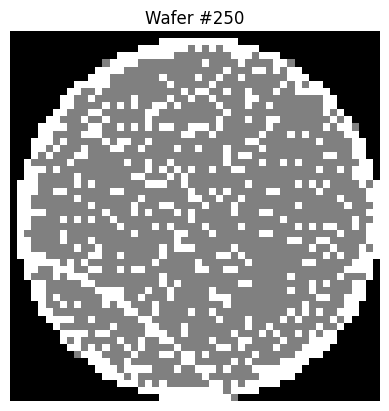

Image size: 52 x 52
Patch size: 13 x 13
Patches per image: 16
Elements per patch (dim): 169
Num patch (self.num_patches): 16


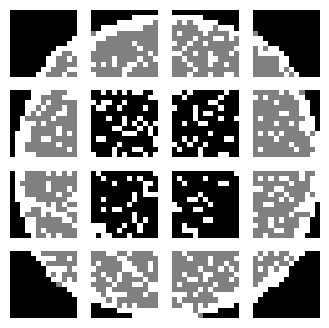

In [ ]:
A_test_patches = VisTransformer(x_train, x_test, y_train, y_test)
A_test_patches.see_patches(num_image=250)

In [11]:
A2 = VisTransformer(x_train, x_test, y_train, y_test)

path = r'C://Users/isang/OneDrive/Desktop/WM/models/ViT_model.pth'

history = A2.train_model(batch_size=512, num_epochs=40, save_path=path)

Epoch 1/40  train_loss=0.5621 train_acc=0.6967  val_loss=0.5890 val_acc=0.7063
Epoch 2/40  train_loss=0.4255 train_acc=0.7631  val_loss=0.3697 val_acc=0.7976
Epoch 3/40  train_loss=0.2871 train_acc=0.8558  val_loss=0.2376 val_acc=0.8829
Epoch 4/40  train_loss=0.2095 train_acc=0.9066  val_loss=0.1590 val_acc=0.9404
Epoch 5/40  train_loss=0.1508 train_acc=0.9393  val_loss=0.1105 val_acc=0.9587
Epoch 6/40  train_loss=0.1185 train_acc=0.9543  val_loss=0.0889 val_acc=0.9675
Epoch 7/40  train_loss=0.1010 train_acc=0.9615  val_loss=0.0808 val_acc=0.9702
Epoch 8/40  train_loss=0.0894 train_acc=0.9667  val_loss=0.0702 val_acc=0.9741
Epoch 9/40  train_loss=0.0800 train_acc=0.9703  val_loss=0.0754 val_acc=0.9727
Epoch 10/40  train_loss=0.0721 train_acc=0.9738  val_loss=0.0702 val_acc=0.9753
Epoch 11/40  train_loss=0.0663 train_acc=0.9760  val_loss=0.0571 val_acc=0.9798
Epoch 12/40  train_loss=0.0606 train_acc=0.9783  val_loss=0.0611 val_acc=0.9781
Epoch 13/40  train_loss=0.0565 train_acc=0.9799  

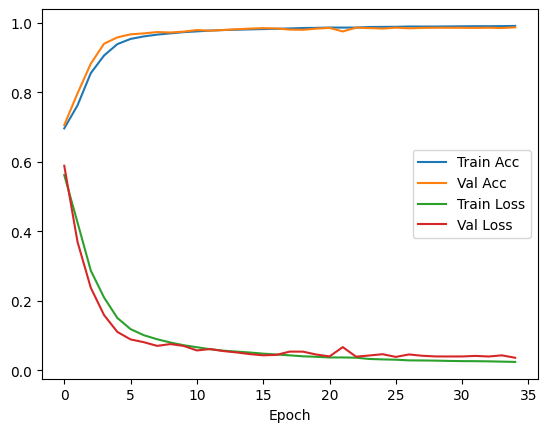

AttributeError: 'VisionTransformer' object has no attribute 'size'

In [12]:
model = A2.load_model(path, plot=True)
A2.model_eval(model, x_test, y_test)

In [14]:
from tqdm import tqdm

batch_size = 256
test_ds = TensorDataset(x_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

model.eval()
all_preds = []
with torch.no_grad():
    for (batch_x,) in tqdm(test_loader, desc="Predicting"):
        logits = model(batch_x)                 
        probs  = torch.sigmoid(logits)          
        all_preds.append(probs.cpu())

predictions = torch.cat(all_preds, dim=0)  

Predicting:   0%|          | 0/30 [00:00<?, ?it/s]

Predicting: 100%|██████████| 30/30 [00:06<00:00,  4.79it/s]


Ground-truth: [0 1 0 0 1 0 0 0]
Predictions : [0 1 0 0 1 0 0 0]


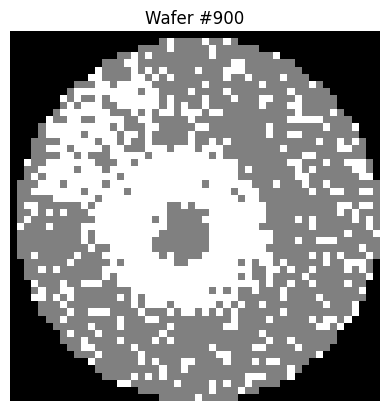

Predicted defects: Donut, Loc, 


In [17]:
pred_img_num = 900

if isinstance(x_test, np.ndarray):
    image = x_test[pred_img_num, 0, :, :]
else:  # torch.Tensor
    image = x_test[pred_img_num, 0].cpu().numpy()

print("Ground-truth:", np.array(y_test[pred_img_num]))
print(
    "Predictions : ["
    + " ".join(f"{val:.0f}" for val in predictions[pred_img_num])
    + "]"
)

plt.imshow(image, cmap='gray')
plt.title(f"Wafer #{pred_img_num}")
plt.axis('off')
plt.show()

label = np.array(
    [f"{val:.0f}" for val in predictions[pred_img_num]]
).astype(float)
print("Predicted defects:", A1.read_label(label))


Ground-truth: [1 0 1 0 0 0 1 0]
Predictions : [1 0 1 0 0 0 1 0]


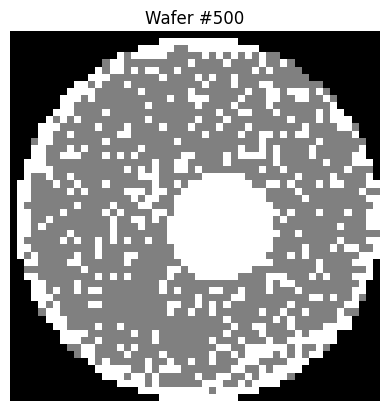

Predicted defects: Center, Edge_Loc, Scratch, 


In [18]:
pred_img_num = 500

if isinstance(x_test, np.ndarray):
    image = x_test[pred_img_num, 0, :, :]
else:  # torch.Tensor
    image = x_test[pred_img_num, 0].cpu().numpy()

print("Ground-truth:", np.array(y_test[pred_img_num]))
print(
    "Predictions : ["
    + " ".join(f"{val:.0f}" for val in predictions[pred_img_num])
    + "]"
)

plt.imshow(image, cmap='gray')
plt.title(f"Wafer #{pred_img_num}")
plt.axis('off')
plt.show()

label = np.array(
    [f"{val:.0f}" for val in predictions[pred_img_num]]
).astype(float)
print("Predicted defects:", A1.read_label(label))


Ground-truth: [0 0 0 1 1 0 0 0]
Predictions : [0 0 0 1 1 0 0 0]


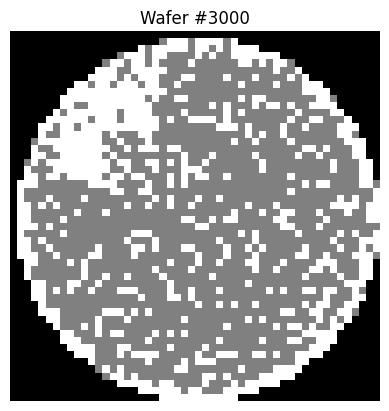

Predicted defects: Edge_Ring, Loc, 


In [19]:
pred_img_num = 3000

if isinstance(x_test, np.ndarray):
    image = x_test[pred_img_num, 0, :, :]
else:  # torch.Tensor
    image = x_test[pred_img_num, 0].cpu().numpy()

print("Ground-truth:", np.array(y_test[pred_img_num]))
print(
    "Predictions : ["
    + " ".join(f"{val:.0f}" for val in predictions[pred_img_num])
    + "]"
)

plt.imshow(image, cmap='gray')
plt.title(f"Wafer #{pred_img_num}")
plt.axis('off')
plt.show()

label = np.array(
    [f"{val:.0f}" for val in predictions[pred_img_num]]
).astype(float)
print("Predicted defects:", A1.read_label(label))


Ground-truth: [1 0 0 1 0 0 0 0]
Predictions : [1 0 0 1 0 0 0 0]


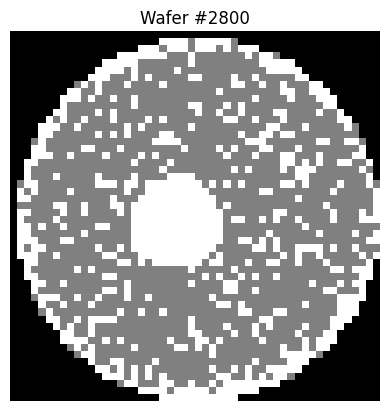

Predicted defects: Center, Edge_Ring, 


In [21]:
pred_img_num = 2800

if isinstance(x_test, np.ndarray):
    image = x_test[pred_img_num, 0, :, :]
else:  # torch.Tensor
    image = x_test[pred_img_num, 0].cpu().numpy()

print("Ground-truth:", np.array(y_test[pred_img_num]))
print(
    "Predictions : ["
    + " ".join(f"{val:.0f}" for val in predictions[pred_img_num])
    + "]"
)

plt.imshow(image, cmap='gray')
plt.title(f"Wafer #{pred_img_num}")
plt.axis('off')
plt.show()

label = np.array(
    [f"{val:.0f}" for val in predictions[pred_img_num]]
).astype(float)
print("Predicted defects:", A1.read_label(label))
